In [1]:
%cd "~/Skorch/ProtienDT/Fang'sTask"

/home/myf/Skorch/ProtienDT/Fang'sTask


In [2]:
import torch #type:ignore
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:",device)

import numpy as np #type:ignore
from meta_net import *
import MoNet as mn
from sklearn.pipeline import Pipeline #type:ignore
from sklearn.preprocessing import StandardScaler #type:ignore
from sklearn.decomposition import PCA #type:ignore

def model_init(module,jobName,load_mode=0):
    # 回调函数#type:ignore
    from skorch.callbacks import Checkpoint, TrainEndCheckpoint , EarlyStopping #type:ignore
    from meta_net.load import LoadCopyState
    cp_val = Checkpoint(dirname="model/"+jobName,f_pickle="model.pt",monitor='valid_loss_best',fn_prefix='val_')#type:ignore
    cp_end = TrainEndCheckpoint(dirname="model/"+jobName,f_pickle="model.pt",fn_prefix='end_')
    init_state=[None,LoadInitState(cp_val),LoadCopyState(cp_val),LoadCopyState(cp_end),LoadInitState(cp_end)][load_mode]

    # 模型运行
    module.set_params(
        optimizer=torch.optim.NAdam,  # 优化器 #type:ignore
        max_epochs=100,  # 最大迭代次数
        batch_size=128,  # 批次大小
        callbacks=[EarlyStopping(monitor='valid_loss',patience=10,load_best=False), #type:ignore
                   init_state,cp_val,cp_end], 
        device=device,  # 使用cpu或者cuda #type:ignore
        warm_start=True
    )

    model = Pipeline([('sc',StandardScaler()),('pca',PCA(n_components=256)),('nn',module)])
    print(model)
    return model

def run_model(model,X, y):
    from sklearn.model_selection import train_test_split #type:ignore
    from torchsummary import summary
    summary((module:=model['nn']).module,input_data=[256],depth=128)
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=Y2, test_size=0.2, random_state=2023)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1, random_state=2023)
    model.fit(train_X,train_y)
    
    print(train_score:="train_score: %.3f"%model.score(train_X,train_y)+f" num:{len(train_X)}")
    print(valid_score:="valid_score: %.3f"%model.score(valid_X,valid_y)+f" num:{len(valid_X)}")
    print(test_score :="test_score : %.3f"%model.score(test_X,test_y)+f" num:{len(test_X)}")
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import sklearn.metrics as M
    fig,axs=plt.subplots(1,4,figsize=(20,4))
    
    # print(M.classification_report(y,model.predict(X),zero_division=0))
    pd.DataFrame(module.history[:,label:=('train_loss','dur','valid_loss')],columns=label).plot(ax=axs[0])
    axs[0].set_title(f"Best epoch:{len(best:=module.history[:,'valid_loss_best'])-best[::-1].index(True)}")
    pd.DataFrame([*(y_true:=train_y).T,*(y_pred:=model.predict(train_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[1])
    # M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=train_y,y_pred=model.predict(train_X))).plot(ax=axs[1])
    axs[1].set_title(train_score)
    pd.DataFrame([*(y_true:=test_y).T,*(y_pred:=model.predict(test_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[2])
    # M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=test_y,y_pred=model.predict(test_X))).plot(ax=axs[2])
    axs[2].set_title(test_score)
    pd.DataFrame(PCA(2).fit_transform(X)).plot.scatter(x=0,y=1,c=abs((y_pred:=model.predict(X))-y),cmap='viridis',ax=axs[3])
    axs[3].set_title(M.mean_absolute_percentage_error(y,y_pred))
    plt.suptitle(jobName)
    plt.tight_layout()
    
    torch.save(model,f"model/{jobName}.final.pt")

device: cuda
pytorch: 2.1.1+cu121 device: cuda


In [6]:
!nvidia-smi

Thu Nov 30 17:26:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:D1:00.0 Off |                  Off |
| 30%   24C    P8               8W / 450W |  17560MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

筛选

In [225]:
import os
# 加载数据
vocab = "-ACDEFGHIKLMNPQRSTVWYUX"
Wild_data = pd.read_pickle('./data/data.pkl').iloc[-1,:]
Wild_Seq = Wild_data['Sequence']

def load_mutant(Embedding="seqs_esm2_t6_8M_UR50D"):
    file_dir=f"./data/Mutant_Xdata_{Embedding}.pkl"
    if not os.path.exists(file_dir):
        # 突变数据
        Mutant_Seqs=[]
        for i in range(len(Wild_Seq)):
            Mutant_Seqs+=[ Wild_Seq[:i]+v+Wild_Seq[i+1:] for v in vocab]    

        # 编码数据
        from meta_net import tokenizer
        from tqdm import tqdm
        model_load = tokenizer.EsmModelLoad(model = Embedding[5:] ,device= device)

        Mutant_Xdata=[]
        for i in tqdm(range(len(Wild_Seq))):
            Mutant_Xdata+=tokenizer.EsmEncoder(Mutant_Seqs[i*len(vocab):(i+1)*len(vocab)],vocab = vocab, model_load=model_load)
        
        pd.to_pickle(Mutant_Xdata,file_dir)
    else:
        Mutant_Xdata=pd.read_pickle(file_dir)
    Mutant_Xdata=np.array(Mutant_Xdata)
    print("Mutant_Xdata shape:",Mutant_Xdata.shape)
    return Mutant_Xdata

Mutant_Xdata shape: (7268, 320)
Protein                                                                        Target-Protein
Sequence                                    MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
len                                                                                       316
Similarity plus ratio/Number of products                                             0.609867
Number of products                                                                          3
Final product similarity                                                             0.000025
Str_X                                       MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
Name: 10975, dtype: object
[[26.06782]]


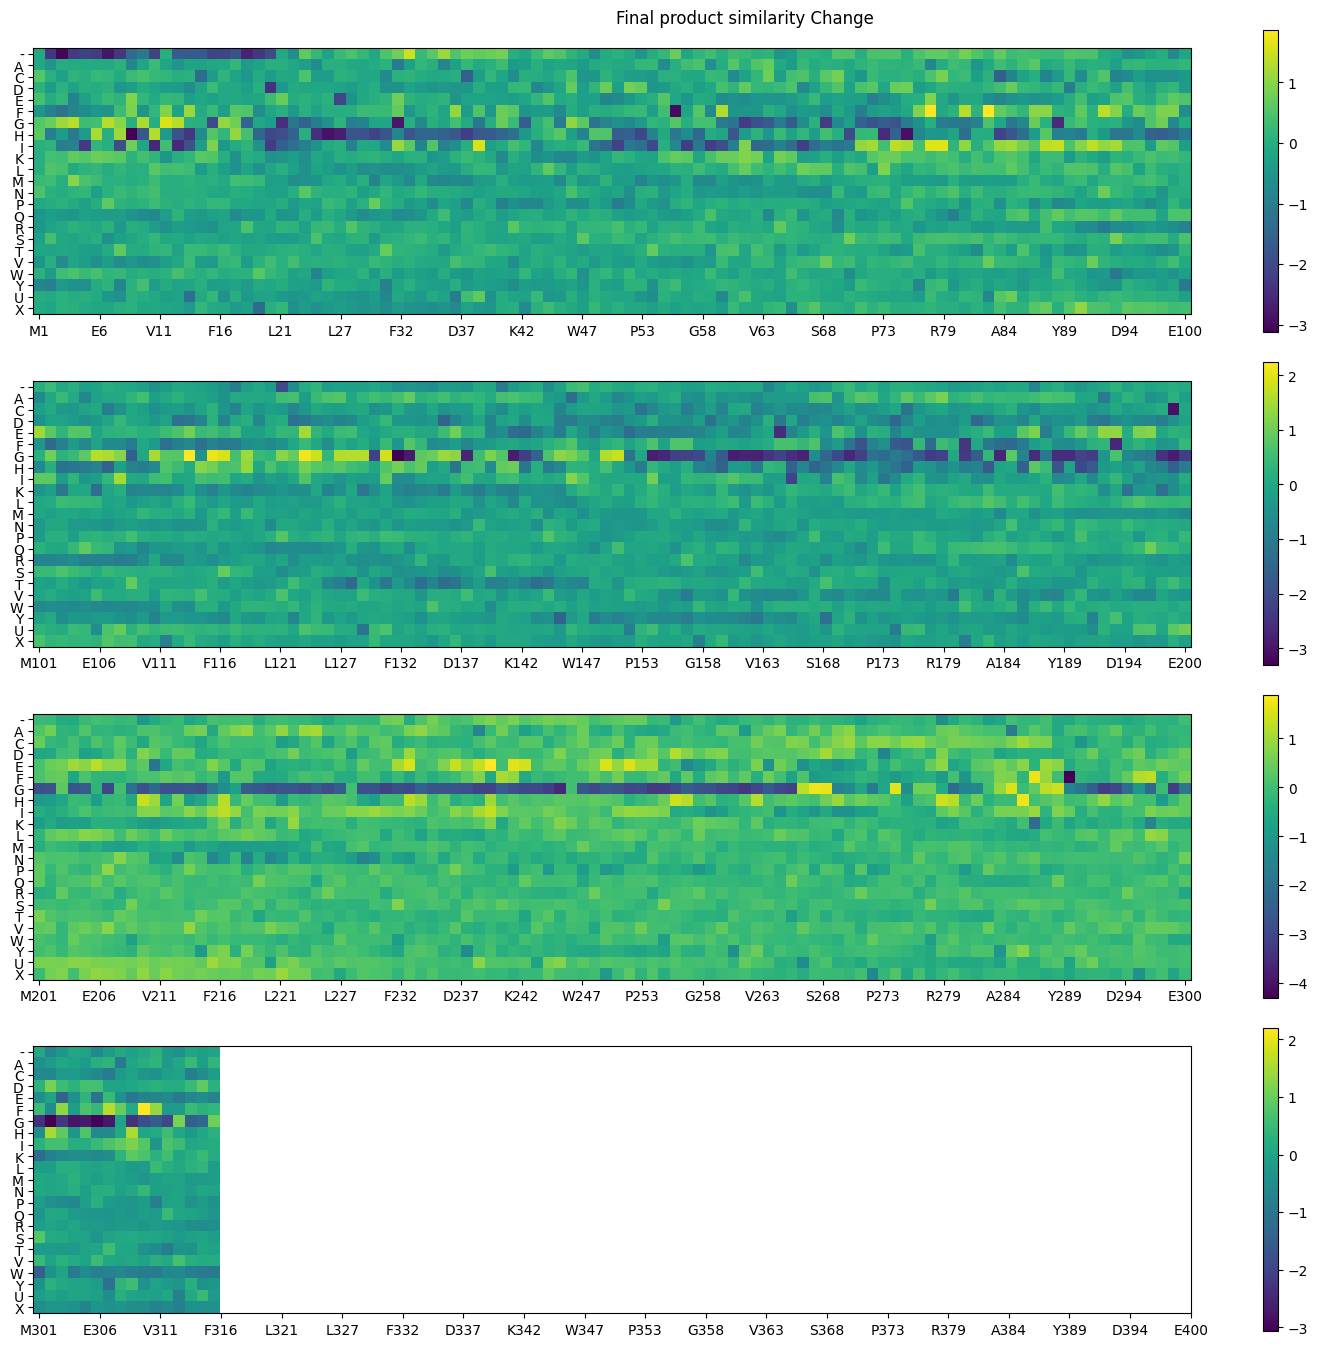

In [1407]:
model="NormMLP_Reg_Y3"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载模型
model = torch.load((f'./model/{jobName}.final.pt'))
Mutant_X = load_mutant(Embedding)
print(Wild_data)
print(Wild_y_pred:=model.predict(Mutant_X[vocab.index('M'):vocab.index('M')+1]))

d_Y3=d_Mutant_y_pred=model.predict(Mutant_X).reshape(len(vocab),-1)-Wild_y_pred

fig,axs=plt.subplots((nrows:=len(Wild_Seq)//100+1),1,figsize=(100*0.15,len(vocab)*0.15*nrows)) # type: ignore
for i in range(nrows):
    ax=axs[i].imshow(d_Mutant_y_pred[:,i*100:(i+1)*100],cmap='viridis')
    axs[i].set_xticks(xt:=np.linspace(0,99,20),
                      [ f"{Wild_Seq[t]}{t+100*i+1}" for t in xt.astype(int)])
    axs[i].set_yticks(np.linspace(0,len(vocab)-1,len(vocab)).astype(int),vocab)
    fig.colorbar(ax, ax=axs[i])
plt.suptitle("Final product similarity Change")
plt.tight_layout()

Mutant_Xdata shape: (7268, 320)
Protein                                                                        Target-Protein
Sequence                                    MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
len                                                                                       316
Similarity plus ratio/Number of products                                             0.609867
Number of products                                                                          3
Final product similarity                                                             0.000025
Str_X                                       MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
Name: 10975, dtype: object
[3]


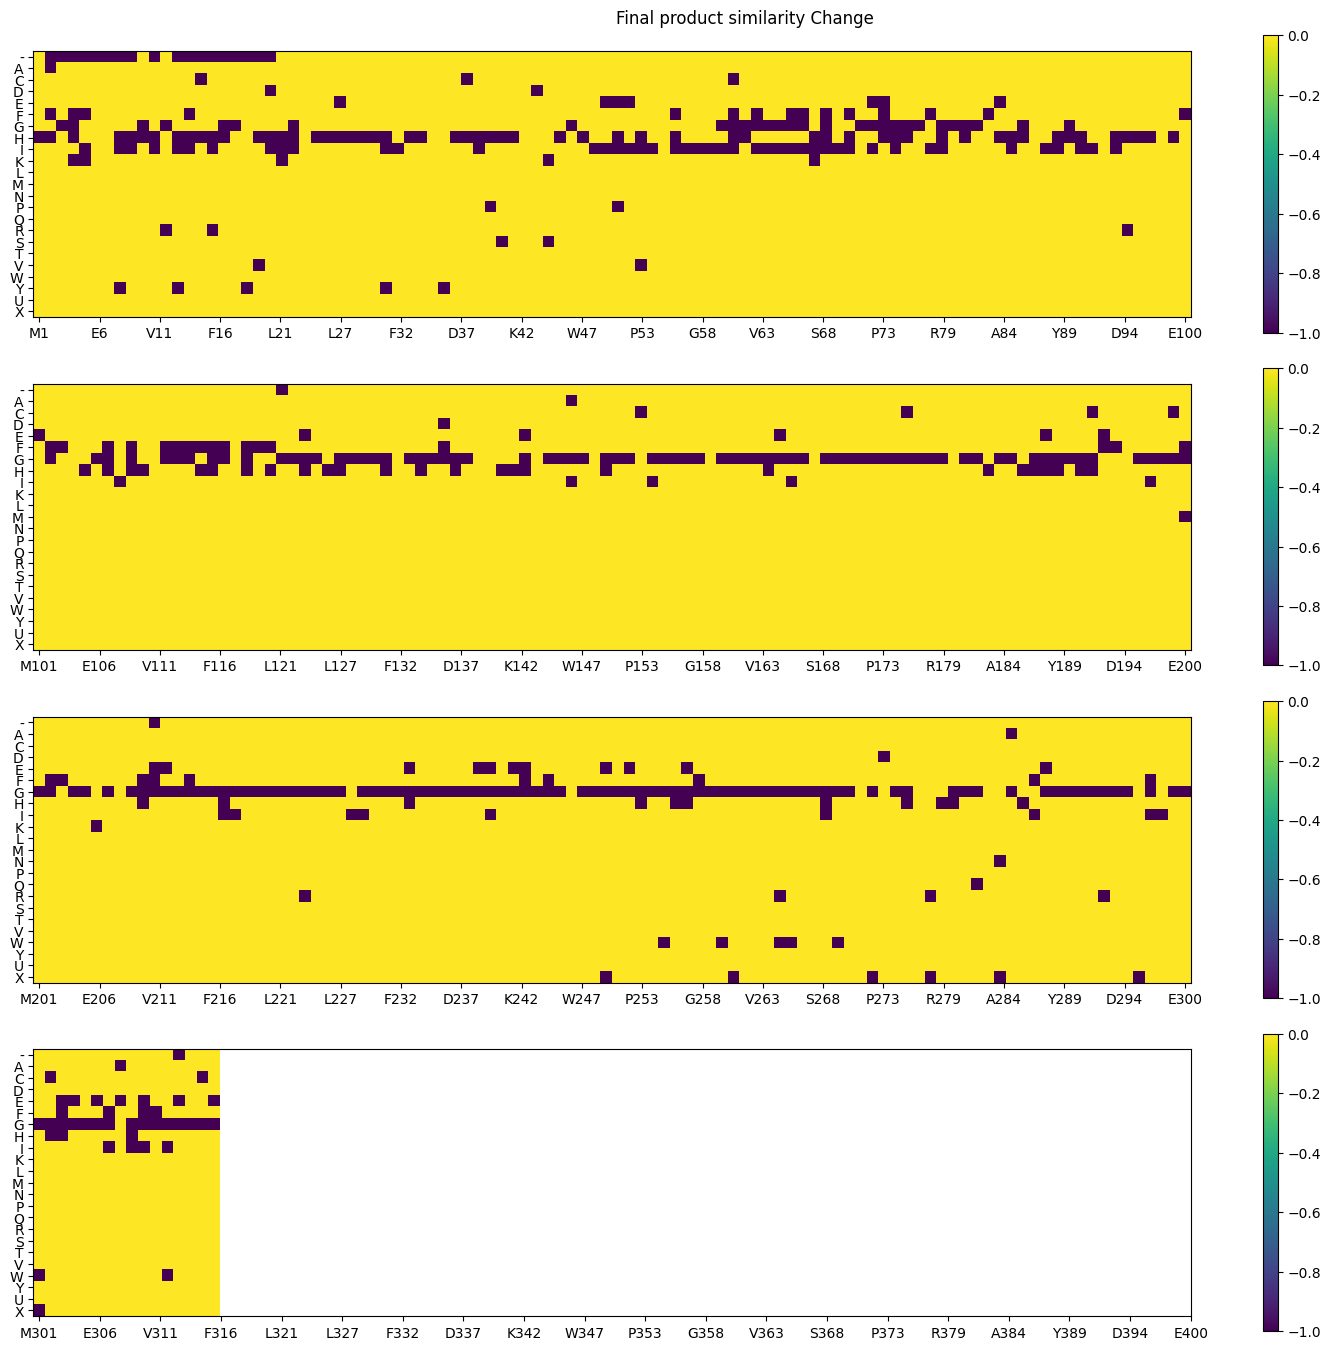

In [228]:
model="NormMLP_Cls_Y2"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载模型
model = torch.load((f'./model/{jobName}.final.pt'))
Mutant_X = load_mutant(Embedding)
print(Wild_data)
print(Wild_y_pred:=model.predict(Mutant_X[vocab.index('M'):vocab.index('M')+1]))

d_Y2=d_Mutant_y_pred=model.predict(Mutant_X).reshape(len(vocab),-1)-Wild_y_pred

fig,axs=plt.subplots((nrows:=len(Wild_Seq)//100+1),1,figsize=(100*0.15,len(vocab)*0.15*nrows)) # type: ignore
for i in range(nrows):
    ax=axs[i].imshow(d_Mutant_y_pred[:,i*100:(i+1)*100],cmap='viridis')
    axs[i].set_xticks(xt:=np.linspace(0,99,20),
                      [ f"{Wild_Seq[t]}{t+100*i+1}" for t in xt.astype(int)])
    axs[i].set_yticks(np.linspace(0,len(vocab)-1,len(vocab)).astype(int),vocab)
    fig.colorbar(ax, ax=axs[i])
plt.suptitle("Final product similarity Change")
plt.tight_layout()

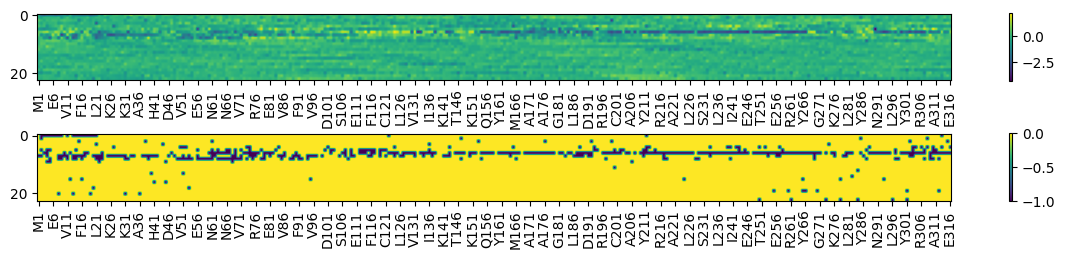

In [1439]:
fig, axs = plt.subplots(2,1, figsize=(12, 2.5))
for i,d_Y in enumerate([d_Y3,d_Y2]):
    ax=axs[i].imshow(d_Y)
    axs[i].set_xticks(xt:=np.array(list(range(0,316,5))),
                      [ f"{Wild_Seq[i]}{i+1}" for i in xt.astype(int)],rotation=90)
    fig.colorbar(ax, ax=axs[i])
plt.tight_layout()

[[26.06782]] 0.11826881766319275 0.05661669373512268 0.10061166435480118
0.11296261847019196 0.0009357482194900513 -0.11152629554271698 0.061307232826948166 0.030366942286491394 -0.06662130355834961


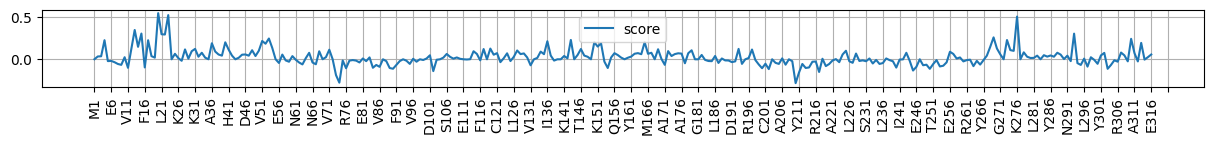

In [1421]:
d_Y = []
for y3,y2 in zip(d_Y3.T,d_Y2.T):
    d_y3=np.std([i for i in y3 if i>0])/np.sum([i for i in y3 if i>0])+\
         np.std([i for i in y3 if i<0])/np.sum([i for i in y3 if i<0])
    d_y2=np.sum(y2)
    d_Y+=[d_y3*(-d_y2)]
d_Y=np.array(d_Y)

pd.DataFrame(d_Y,columns=['score']).plot(figsize=(15,1))
plt.xticks(xt:=np.linspace(0,320,320//5+1),[ f"{Wild_Seq[i]}{i+1}" for i in xt[:-1].astype(int)]+[''],rotation=90)
plt.grid()
# plt.title("Final product similarity Change")
print(Wild_y_pred,d_Y[169-1],d_Y[224-1],d_Y[225-1])
print(d_Y[71-1],d_Y[72-1],d_Y[90-1],d_Y[174-1],d_Y[287-1],d_Y[295-1])

,index,score
index,,
C121,C121,0.072413
E163,E163,0.072550
G65,G65,0.076349
T243,T243,0.076601
I167,I167,0.076918
E256,E256,0.088829
K134,K134,0.090486
S68,S68,0.094477
L114,L114,0.094996


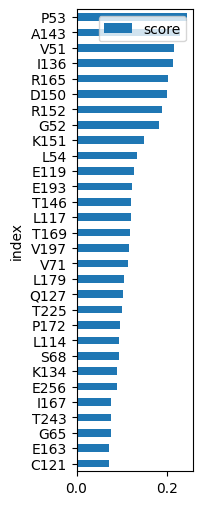

In [1438]:
df=pd.DataFrame(d_Y,columns=['score'],index=[f"{Wild_Seq[i]}{i+1}" for i in range(len(Wild_Seq))]).iloc[50:-50]
df=df[df['score']>0].reset_index().sort_values(by='score')
df=df[-30:]
# df=df.sort_index()
df.index=df['index']
df.plot.barh(figsize=(1.5,6))
df